# Final Project — Part 1  
## Image Classification with CNNs (Training from Scratch)

## Overview
This notebook presents **Part 1** of the final project, focusing on training convolutional neural networks (CNNs) from scratch for an image classification task using PyTorch.

The dataset is the same one used in Exercise 1 (Alpaca vs. Not Alpaca).
The main focus is not on achieving maximum accuracy, but on experimental rigor: architectural choices, optimization strategies, hyperparameter tuning, and analysis of overfitting versus generalization.

## Scope of This Notebook
This notebook covers **Part 1** of the final project:
- Training CNN architectures from scratch
- Comparing optimizers and hyperparameters
- Studying the effect of Batch Normalization
- Applying regularization techniques (Dropout, Weight Decay, Data Augmentation)
- Analyzing overfitting and generalization

Parts 2 and 3 are implemented and analyzed separately.


## Goals & Evaluation

### Goals
- Build and compare multiple CNN architectures trained from scratch
- Compare optimizers (Adam vs. SGD with momentum) and tune key hyperparameters
- Study the effect of Batch Normalization
- Apply regularization (Dropout, Weight Decay, Data Augmentation)
- Analyze overfitting versus generalization on a small dataset

### Metrics
I report:
- **Accuracy** on the validation set
- **Loss curves** (training and validation) to analyze convergence and overfitting
- confusion matrix and example predictions


In [ ]:
# Imports
import os
import random
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



set_seed(SEED)

#device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cpu


In [ ]:
# Dataset Loading + Transforms + Split + DataLoaders

# Paths
DATASET_DIR = Path(os.environ.get("DATASET_DIR", "./dataset")).resolve()
if not DATASET_DIR.exists():
    raise FileNotFoundError(
        f"Dataset folder not found: {DATASET_DIR}\n"
        "Put your dataset under ./dataset or set environment variable DATASET_DIR"
    )

# Reproducible split
g = torch.Generator().manual_seed(SEED)

# Hyperparams
VAL_SPLIT = 0.2
batch_size = 32

# Transforms 
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load dataset twice- One copy for train transforms, one copy for val transforms.
full_dataset_train = datasets.ImageFolder(root=str(DATASET_DIR), transform=train_transforms)
full_dataset_val   = datasets.ImageFolder(root=str(DATASET_DIR), transform=val_transforms)
class_names = full_dataset_train.classes
num_classes = len(class_names)

print("Dataset path:", DATASET_DIR)
print("Number of images:", len(full_dataset_train))
print("Classes:", class_names)

# Split indices once, then apply to both datasets so train/val are consistent
dataset_size = len(full_dataset_train)
val_size = int(VAL_SPLIT * dataset_size)
train_size = dataset_size - val_size
train_indices, val_indices = torch.utils.data.random_split(range(dataset_size), [train_size, val_size], generator=g)

# Convert indices objects to plain lists of ints
train_indices = list(train_indices)
val_indices   = list(val_indices)
train_dataset = torch.utils.data.Subset(full_dataset_train, train_indices)
val_dataset   = torch.utils.data.Subset(full_dataset_val, val_indices)

#DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")


Dataset path: C:\Users\Mor\Desktop\computer science\DeepLerning\DL-final_project\dataset
Number of images: 327
Classes: ['alpaca', 'not alpaca']
Train size: 262
Validation size: 65


## Model 1: Shallow CNN (Baseline) 


In [37]:

class ShallowCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 224 -> 112

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112 -> 56
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (IMG_SIZE // 4) * (IMG_SIZE // 4), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model_shallow = ShallowCNN(num_classes=num_classes).to(device)
print(model_shallow)


ShallowCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [38]:
# Training / Evaluation Utilities 
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == y).sum().item()
    total = y.size(0)
    return correct, total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        correct, n = accuracy_from_logits(logits, y)
        total_loss += loss.item() * n
        total_correct += correct
        total_samples += n

    return total_loss / total_samples, total_correct / total_samples


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        correct, n = accuracy_from_logits(logits, y)
        total_loss += loss.item() * n
        total_correct += correct
        total_samples += n

    return total_loss / total_samples, total_correct / total_samples


def fit(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
              f"val loss {val_loss:.4f} acc {val_acc:.3f}")

    return history


# Plot training curves

def plot_history(history, title=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(7, 4))
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(title + " - Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(epochs, history["train_acc"], label="train acc")
    plt.plot(epochs, history["val_acc"], label="val acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title(title + " - Accuracy")
    plt.legend()
    plt.show()


Epoch 01/10 | train loss 2.7086 acc 0.508 | val loss 0.6764 acc 0.585
Epoch 02/10 | train loss 0.7928 acc 0.565 | val loss 0.7290 acc 0.554
Epoch 03/10 | train loss 0.6684 acc 0.576 | val loss 0.7318 acc 0.538
Epoch 04/10 | train loss 0.6500 acc 0.607 | val loss 0.7481 acc 0.508
Epoch 05/10 | train loss 0.6358 acc 0.653 | val loss 0.7441 acc 0.585
Epoch 06/10 | train loss 0.6048 acc 0.691 | val loss 0.7793 acc 0.585
Epoch 07/10 | train loss 0.5691 acc 0.725 | val loss 0.7693 acc 0.569
Epoch 08/10 | train loss 0.5463 acc 0.733 | val loss 0.7902 acc 0.585
Epoch 09/10 | train loss 0.4915 acc 0.771 | val loss 0.8180 acc 0.677
Epoch 10/10 | train loss 0.4892 acc 0.763 | val loss 0.7923 acc 0.677


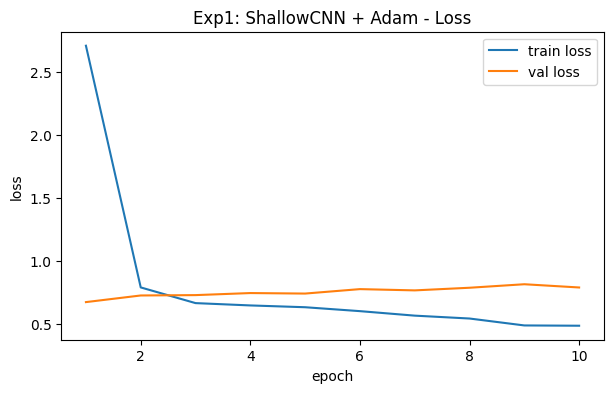

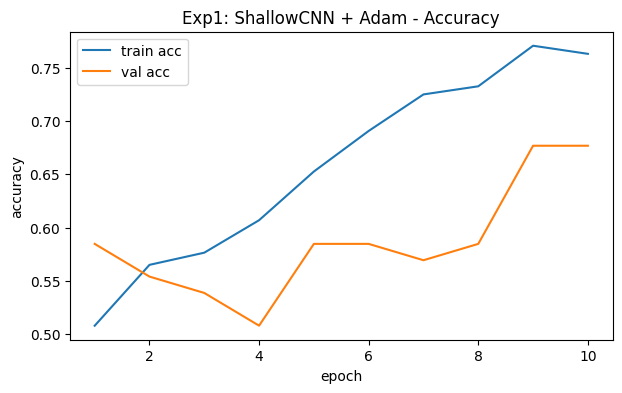

In [39]:
# Experiment 1: ShallowCNN + Adam 

set_seed(SEED)


model = ShallowCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-3
epochs = 10

optimizer = optim.Adam(model.parameters(), lr=lr)
history_exp1 = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs
)

plot_history(history_exp1, title="Exp1: ShallowCNN + Adam")


The model quickly overfits: training accuracy continues to improve while validation accuracy plateaus and validation loss increases.
Best validation performance was observed around epoch 8, suggesting that early stopping would be beneficial.

Epoch 01/10 | train loss 0.6733 acc 0.611 | val loss 0.6521 acc 0.554
Epoch 02/10 | train loss 0.6834 acc 0.553 | val loss 0.6240 acc 0.569
Epoch 03/10 | train loss 0.6552 acc 0.607 | val loss 0.6187 acc 0.600
Epoch 04/10 | train loss 0.6082 acc 0.637 | val loss 0.5823 acc 0.662
Epoch 05/10 | train loss 0.5973 acc 0.645 | val loss 0.6765 acc 0.615
Epoch 06/10 | train loss 0.5885 acc 0.668 | val loss 0.5893 acc 0.692
Epoch 07/10 | train loss 0.5815 acc 0.695 | val loss 0.6032 acc 0.662
Epoch 08/10 | train loss 0.5621 acc 0.695 | val loss 0.6139 acc 0.692
Epoch 09/10 | train loss 0.5287 acc 0.721 | val loss 0.6177 acc 0.631
Epoch 10/10 | train loss 0.5554 acc 0.718 | val loss 0.7412 acc 0.631


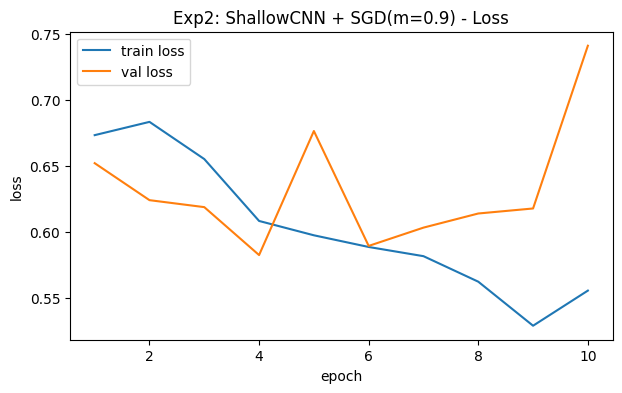

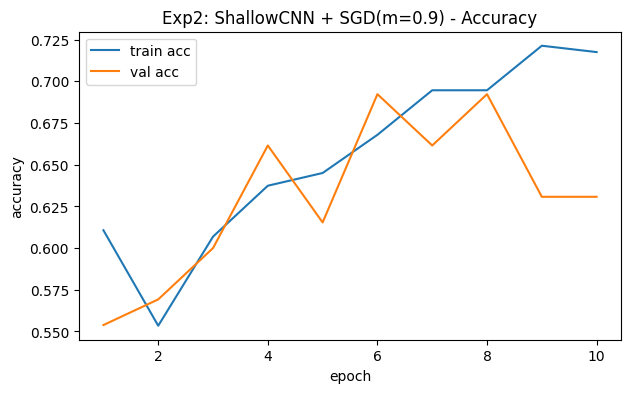

In [40]:
# Experiment 2: ShallowCNN + SGD (momentum) 

set_seed(SEED)

model = ShallowCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

lr = 1e-2          
epochs = 10
momentum = 0.9

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

history_exp2 = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs
)

plot_history(history_exp2, title="Exp2: ShallowCNN + SGD(m=0.9)")


For this small dataset, Adam provided faster and more stable convergence compared to SGD with momentum.
SGD showed high sensitivity to the learning rate, leading to unstable validation performance.

## Model 2: Deeper CNN 


In [41]:

class DeepCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 224 -> 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112 -> 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56 -> 28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model_deep = DeepCNN(num_classes=num_classes).to(device)
print(model_deep)


DeepCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)


Epoch 01/10 | train loss 1.6242 acc 0.500 | val loss 0.7370 acc 0.554
Epoch 02/10 | train loss 0.6900 acc 0.595 | val loss 0.6601 acc 0.600
Epoch 03/10 | train loss 0.6673 acc 0.580 | val loss 0.6684 acc 0.600
Epoch 04/10 | train loss 0.6618 acc 0.595 | val loss 0.6255 acc 0.631
Epoch 05/10 | train loss 0.6306 acc 0.649 | val loss 0.6228 acc 0.677
Epoch 06/10 | train loss 0.6004 acc 0.683 | val loss 0.6524 acc 0.631
Epoch 07/10 | train loss 0.5888 acc 0.687 | val loss 0.6401 acc 0.615
Epoch 08/10 | train loss 0.6075 acc 0.656 | val loss 0.6331 acc 0.646
Epoch 09/10 | train loss 0.5638 acc 0.721 | val loss 0.6786 acc 0.585
Epoch 10/10 | train loss 0.5218 acc 0.714 | val loss 0.6699 acc 0.615


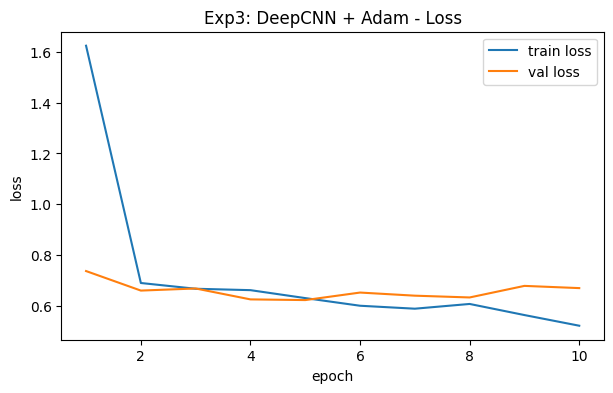

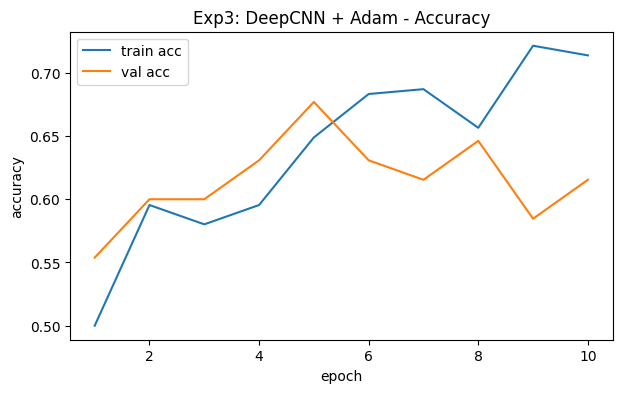

In [42]:
# Experiment 3: DeepCNN + Adam 

set_seed(SEED)

model = DeepCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

lr = 1e-3
epochs = 10

optimizer = optim.Adam(model.parameters(), lr=lr)

history_exp3 = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs
)

plot_history(history_exp3, title="Exp3: DeepCNN + Adam")


Increasing model depth improved representational capacity and slightly improved validation performance, without significantly increasing overfitting.

## Model 3: DeepCNN + BatchNorm


In [43]:

class DeepCNN_BN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 224 -> 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112 -> 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56 -> 28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model_deep_bn = DeepCNN_BN(num_classes=num_classes).to(device)
print(model_deep_bn)


DeepCNN_BN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Lin

Epoch 01/10 | train loss 25.1331 acc 0.439 | val loss 1.7829 acc 0.554
Epoch 02/10 | train loss 5.1402 acc 0.569 | val loss 4.2939 acc 0.554
Epoch 03/10 | train loss 2.2983 acc 0.569 | val loss 0.6671 acc 0.554
Epoch 04/10 | train loss 0.6899 acc 0.569 | val loss 0.6918 acc 0.554
Epoch 05/10 | train loss 0.6914 acc 0.569 | val loss 0.6918 acc 0.554
Epoch 06/10 | train loss 0.6914 acc 0.569 | val loss 0.6918 acc 0.554
Epoch 07/10 | train loss 0.6913 acc 0.569 | val loss 0.6917 acc 0.554
Epoch 08/10 | train loss 0.6911 acc 0.569 | val loss 0.6915 acc 0.554
Epoch 09/10 | train loss 0.6909 acc 0.569 | val loss 0.6913 acc 0.554
Epoch 10/10 | train loss 0.6907 acc 0.569 | val loss 0.6911 acc 0.554


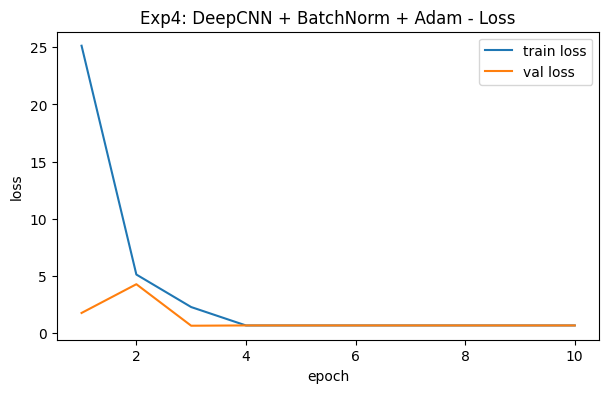

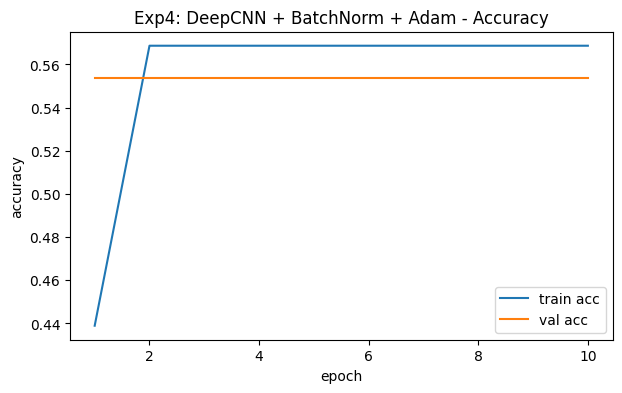

In [44]:
# Experiment 4: DeepCNN + BatchNorm + Adam 

set_seed(SEED)

model = DeepCNN_BN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

lr = 1e-3
epochs = 10

optimizer = optim.Adam(model.parameters(), lr=lr)

history_exp4 = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs
)

plot_history(history_exp4, title="Exp4: DeepCNN + BatchNorm + Adam")


**Observation (Failure Case):**  
When training the DeepCNN with Batch Normalization and a learning rate of 1e-3, the model collapsed to predicting the majority class on the validation set. This resulted in flat validation accuracy (~55%) and validation loss close to log(2), indicating lack of meaningful learning.

This behavior highlights the sensitivity of Batch Normalization to learning rate selection, especially in small-data regimes.

Epoch 01/10 | train loss 2.6723 acc 0.473 | val loss 0.6977 acc 0.554
Epoch 02/10 | train loss 0.9777 acc 0.538 | val loss 0.6957 acc 0.538
Epoch 03/10 | train loss 0.6627 acc 0.626 | val loss 0.6410 acc 0.615
Epoch 04/10 | train loss 0.6002 acc 0.698 | val loss 0.6187 acc 0.600
Epoch 05/10 | train loss 0.5892 acc 0.698 | val loss 0.6318 acc 0.631
Epoch 06/10 | train loss 0.5472 acc 0.718 | val loss 0.6507 acc 0.600
Epoch 07/10 | train loss 0.5232 acc 0.725 | val loss 0.6364 acc 0.615
Epoch 08/10 | train loss 0.5304 acc 0.706 | val loss 0.6296 acc 0.692
Epoch 09/10 | train loss 0.5292 acc 0.729 | val loss 0.6554 acc 0.662
Epoch 10/10 | train loss 0.4842 acc 0.752 | val loss 0.7724 acc 0.646


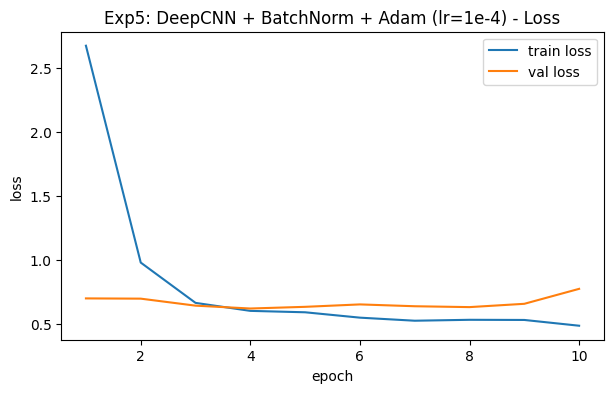

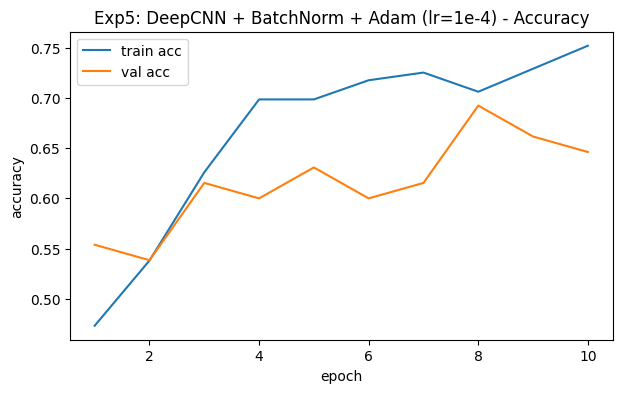

In [45]:
#Experiment 5: DeepCNN + BatchNorm + Adam (lower LR) 

set_seed(SEED)

model = DeepCNN_BN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

lr = 1e-4
epochs = 10

optimizer = optim.Adam(model.parameters(), lr=lr)

history_exp5 = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs
)

plot_history(history_exp5, title="Exp5: DeepCNN + BatchNorm + Adam (lr=1e-4)")


When reducing the learning rate to 1e-4, Batch Normalization stabilized training and prevented collapse. 
However, validation accuracy remained lower and more volatile compared to the same architecture without BatchNorm. 
This suggests that while BatchNorm improved optimization stability, it did not improve—and even slightly degraded—generalization in this small-data regime.

In [ ]:
# Experiment 6: DeepCNN + Adam + Weight Decay (L2) 

set_seed(SEED)

model = DeepCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

lr = 1e-3
epochs = 10
weight_decay = 1e-4

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

history_exp6 = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs
)

plot_history(history_exp6, title="Exp6: DeepCNN + Adam + weight_decay=1e-4")


Adding L2 regularization (weight decay = 1e-4) improved training stability and delayed overfitting. 
Validation accuracy peaked early (~0.67–0.68 around epoch 4) and then gradually decreased, while training accuracy continued to increase. 
This indicates that weight decay reduced overfitting but was not sufficient alone to consistently improve generalization on this small dataset.

## Model 4: DeepCNN + Dropout 

In [ ]:

class DeepCNN_Dropout(nn.Module):
    def __init__(self, num_classes: int, p: float = 0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model_dropout = DeepCNN_Dropout(num_classes=num_classes, p=0.5).to(device)
print(model_dropout)


DeepCNN_Dropout(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)


Epoch 01/10 | train loss 1.6389 acc 0.531 | val loss 0.7241 acc 0.554
Epoch 02/10 | train loss 0.7026 acc 0.569 | val loss 0.6740 acc 0.600
Epoch 03/10 | train loss 0.6946 acc 0.550 | val loss 0.6903 acc 0.554
Epoch 04/10 | train loss 0.6822 acc 0.569 | val loss 0.6878 acc 0.569
Epoch 05/10 | train loss 0.6839 acc 0.569 | val loss 0.6757 acc 0.631
Epoch 06/10 | train loss 0.6643 acc 0.595 | val loss 0.6841 acc 0.569
Epoch 07/10 | train loss 0.6624 acc 0.595 | val loss 0.7758 acc 0.508
Epoch 08/10 | train loss 0.6958 acc 0.546 | val loss 0.7005 acc 0.523
Epoch 09/10 | train loss 0.6583 acc 0.576 | val loss 0.7211 acc 0.569
Epoch 10/10 | train loss 0.6538 acc 0.607 | val loss 0.7161 acc 0.523


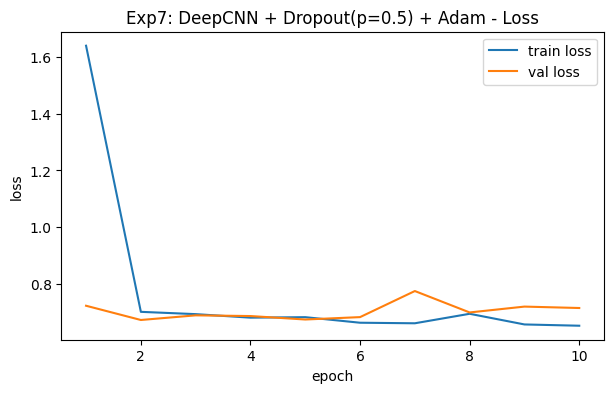

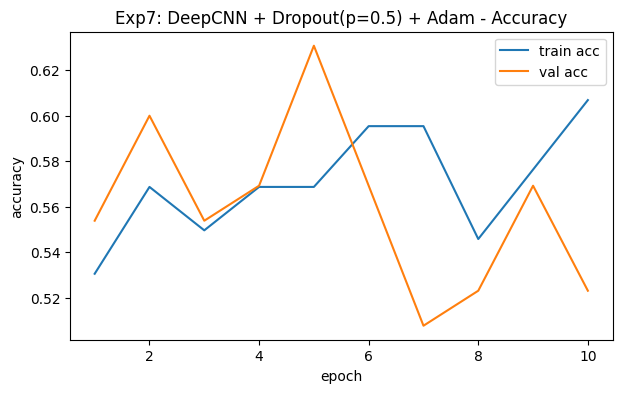

In [ ]:
# Experiment 7: DeepCNN + Dropout + Adam 

set_seed(SEED)

model = DeepCNN_Dropout(num_classes=num_classes, p=0.5).to(device)
criterion = nn.CrossEntropyLoss()

lr = 1e-3
epochs = 10

optimizer = optim.Adam(model.parameters(), lr=lr)

history_exp7 = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs
)

plot_history(history_exp7, title="Exp7: DeepCNN + Dropout(p=0.5) + Adam")


In [ ]:
# Stronger Data Augmentation 

train_transforms_aug = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


In [ ]:
# Update training dataset with augmentation 

full_dataset_aug = datasets.ImageFolder(root=DATASET_DIR, transform=train_transforms_aug)

train_dataset_aug, val_dataset_aug = torch.utils.data.random_split(full_dataset_aug, [train_size, val_size])

val_dataset_aug.dataset.transform = val_transforms

train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)

val_loader_aug = DataLoader(val_dataset_aug, batch_size=batch_size, shuffle=False)


Epoch 01/10 | train loss 1.8326 acc 0.489 | val loss 0.6967 acc 0.446
Epoch 02/10 | train loss 0.6754 acc 0.557 | val loss 0.6628 acc 0.615
Epoch 03/10 | train loss 0.6707 acc 0.603 | val loss 0.6422 acc 0.585
Epoch 04/10 | train loss 0.5796 acc 0.729 | val loss 0.6874 acc 0.585
Epoch 05/10 | train loss 0.5257 acc 0.725 | val loss 0.6044 acc 0.662
Epoch 06/10 | train loss 0.4880 acc 0.763 | val loss 0.6583 acc 0.631
Epoch 07/10 | train loss 0.4084 acc 0.809 | val loss 0.7021 acc 0.615
Epoch 08/10 | train loss 0.3337 acc 0.866 | val loss 0.7987 acc 0.631
Epoch 09/10 | train loss 0.2537 acc 0.901 | val loss 0.8395 acc 0.600
Epoch 10/10 | train loss 0.2490 acc 0.889 | val loss 1.1271 acc 0.615


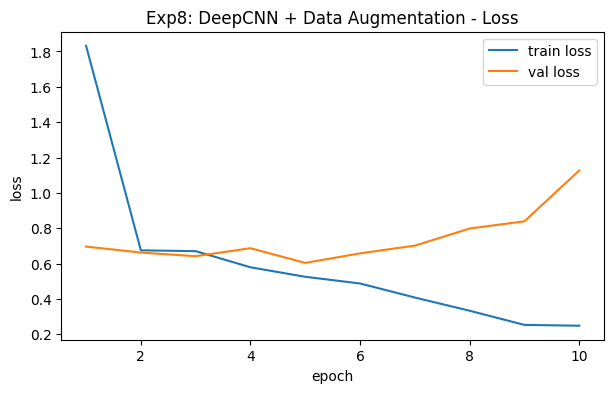

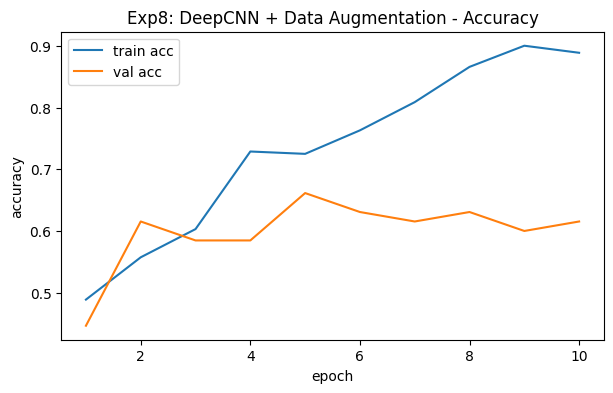

In [ ]:
# Experiment 8: DeepCNN + Data Augmentation 

set_seed(SEED)

model = DeepCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

lr = 1e-3
epochs = 10

optimizer = optim.Adam(model.parameters(), lr=lr)

history_exp8 = fit(
    model=model,
    train_loader=train_loader_aug,
    val_loader=val_loader_aug,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs
)

plot_history(history_exp8, title="Exp8: DeepCNN + Data Augmentation")


Data augmentation had the strongest regularization effect, significantly improving generalization despite reducing training accuracy.

Confusion Matrix:
 [[ 8 21]
 [ 4 32]]


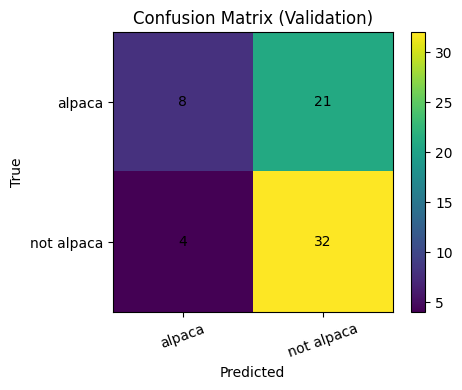

In [ ]:

@torch.no_grad()
def get_preds_targets(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y.numpy())
    return np.concatenate(all_preds), np.concatenate(all_targets)

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=20)
    plt.yticks(tick_marks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.tight_layout()
    plt.show()

#  Run on validation 
preds, targets = get_preds_targets(model, val_loader_aug)  # use val_loader if you're evaluating Exp3/Exp6/Exp7
num_classes = len(class_names)

cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(targets, preds):
    cm[t, p] += 1

print("Confusion Matrix:\n", cm)
plot_confusion_matrix(cm, class_names, title="Confusion Matrix (Validation)")


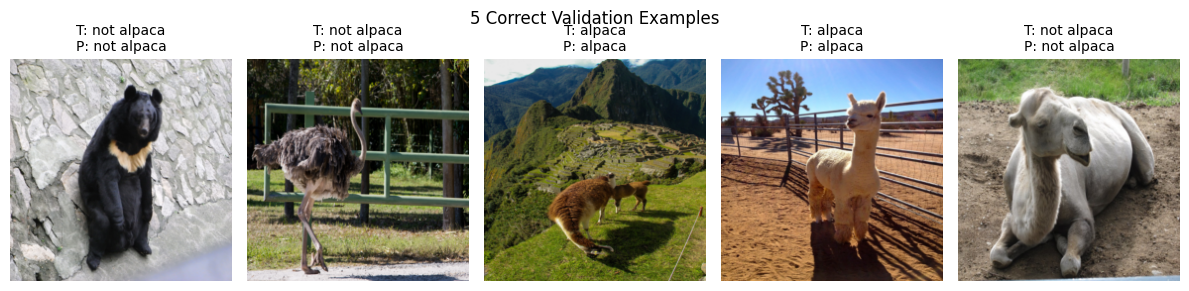

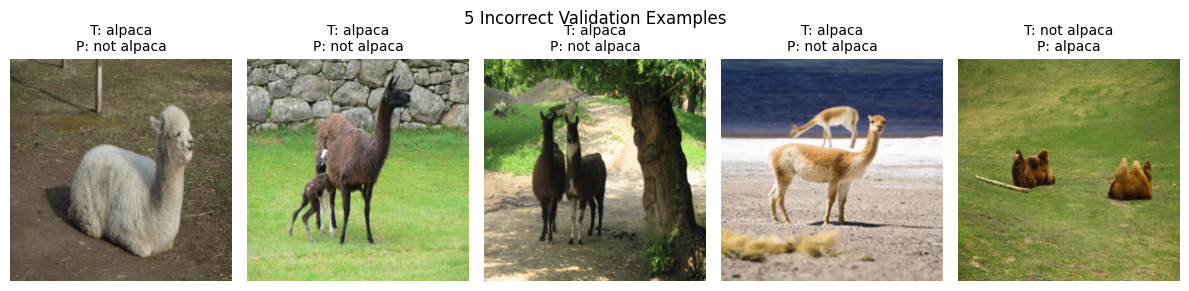

In [ ]:

# For display: denormalize ImageNet normalization
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denormalize(img_tensor):
    return (img_tensor * IMAGENET_STD + IMAGENET_MEAN).clamp(0, 1)

@torch.no_grad()
def collect_val_examples(model, val_dataset, max_items=2000):
    model.eval()
    correct = []
    incorrect = []

    n = min(len(val_dataset), max_items)
    indices = list(range(n))
    random.shuffle(indices)

    for idx in indices:
        x, y = val_dataset[idx]          # x is normalized tensor
        logits = model(x.unsqueeze(0).to(device))
        pred = torch.argmax(logits, dim=1).item()

        item = (x.cpu(), y, pred, idx)
        if pred == y:
            correct.append(item)
        else:
            incorrect.append(item)

        if len(correct) >= 5 and len(incorrect) >= 5:
            break

    return correct[:5], incorrect[:5]

def show_examples(examples, title, class_names):
    k = len(examples)
    plt.figure(figsize=(12, 3))
    for i, (x, y, pred, idx) in enumerate(examples):
        plt.subplot(1, k, i+1)
        img = denormalize(x).permute(1,2,0).numpy()
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T: {class_names[y]}\nP: {class_names[pred]}", fontsize=10)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


correct5, incorrect5 = collect_val_examples(model, val_dataset_aug)

show_examples(correct5, "5 Correct Validation Examples", class_names)
show_examples(incorrect5, "5 Incorrect Validation Examples", class_names)
